<h1>Part 4 - Modeling</h1> <br/>

**View from 30,000 feet**<br/>
-The objective is **"to quantify and rank the factors that impact passenger satisfaction."** <br/> 
-Among those factors, the ones that we would be most **interested in are the ones that we could exert some control** - i.e. those variables in the survey that are asked to be rated from 1 to 5 (i.e. those in "vars_cat_num" in the code).<br/>
-Conceivably, if we could **calibrate a model that would accurately represent passenger satisfaction**, we could **perform sensitivity analysis** around these variables of influence. <br/>
    An example, would be to ask the counterfactual question: **"How would the general satisfaction change if for everyone who rated "Cleanliness" at 3, the "Cleanliness" rating, instead, went up to 4?"**<br/>
-If we performed this analysis for every variable, then we would have a predictive output that the rest of the company could use to help guide short- and long-term projects.



**Implementation Steps**<br/>
-Take a look all variables to have an idea about how the final factor importance could look like.<br/>
-Train two ensemble tree models (Random Forest vs AdaBoost) with cross-validation using grid search for optimal tree depth and decide on one.<br/>
-Retrain the model based on all training data available. <br/>
-Calculate the average impact on satisfaction for all variables at various base levels. <br/>



In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV

**Import Data and Restate Variables**

In [2]:
train_data_final = pd.read_pickle('data/model/train_data_final.pkl')
test_data_final = pd.read_pickle('data/model/test_data_final.pkl')
print('Show Dataset has no NAs:')
print(test_data_final.isna().sum())

vars_cont = ['Age', 'Flight Distance', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']

vars_cat_num = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']

vars_cat_str = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

Show Dataset has no NAs:
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
Relative Arrival Delay               0
dtype: int64


**A Correlation Analysis Before Running A Tree-Based Model**<br/>
This will help us visualize the problem space.


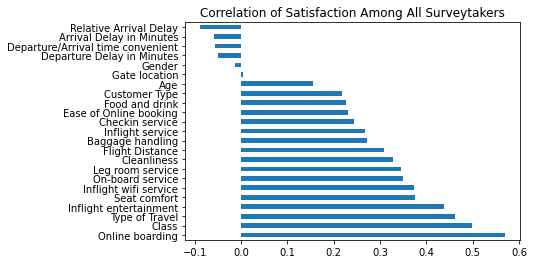

In [3]:
feat_corr_with_sat = train_data_final.corr()['satisfaction'].sort_values(ascending=False).drop(['satisfaction'])
feat_corr_with_sat.plot(kind='barh')
plt.title('Correlation of Satisfaction Among All Surveytakers'); print()

**Use Random Forests to Calibrate the Training Set**<br/>

In [4]:
max_depth_param = 15
param_grid_rf = {'max_depth':list(range(1, max_depth_param + 1))} #default n_estimators for Random Forest is 100.
clf_rf = RandomForestClassifier()

scorer= {'f1_score':make_scorer(f1_score), 
             'precision_score':make_scorer(precision_score),
             'recall_score':make_scorer(recall_score),
             'accuracy_score':make_scorer(accuracy_score)}
clf_rf_cv = GridSearchCV(clf_rf, param_grid_rf, cv=5, n_jobs=-1, scoring = scorer, refit='f1_score', verbose=3)
clf_rf_cv.fit(train_data_final.drop(['satisfaction'], axis=1),train_data_final['satisfaction']);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [5]:
clf_rf_cv_results = pd.DataFrame(clf_rf_cv.cv_results_)

**Use Ada Boost to Calibrate the Training Set**<br/>

In [6]:
param_grid_ada = {'base_estimator__max_depth':list(range(1, max_depth_param + 1)), 'n_estimators':[100]}
clf_tree = DecisionTreeClassifier()
clf_ada = AdaBoostClassifier(clf_tree)
clf_ada_cv = GridSearchCV(clf_ada, param_grid_ada, cv=5, n_jobs=-1, scoring = scorer, refit='f1_score', verbose=3)
clf_ada_cv.fit(train_data_final.drop(['satisfaction'], axis=1),train_data_final['satisfaction'])

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15],
                         'n_estimators': [100]},
             refit='f1_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)},
             verbose=3)

In [7]:
clf_ada_cv_results = pd.DataFrame(clf_ada_cv.cv_results_)

**Decide on the Model**<br/>

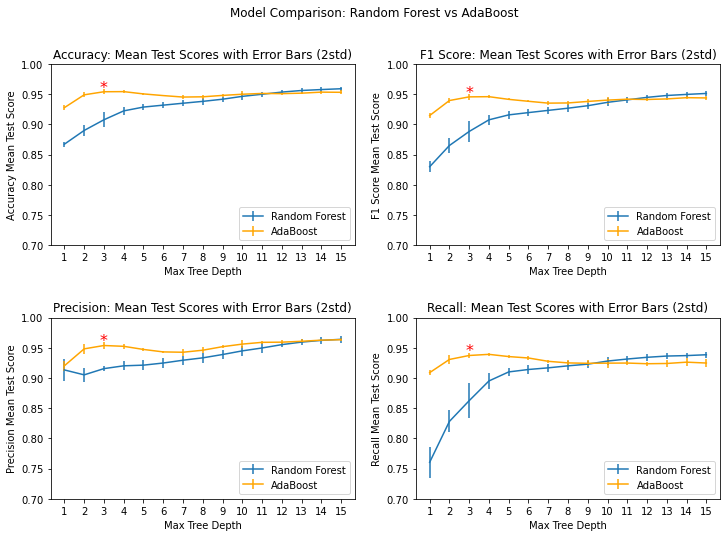

In [8]:
clf_rf_cv_results['Method'] = 'RF'
clf_rf_cv_results['Max Tree Depth'] = list(range(1, max_depth_param+1))

clf_ada_cv_results['Method'] = 'AdaBoost'
clf_ada_cv_results['Max Tree Depth'] = list(range(1, max_depth_param+1))


combined_cv_results = pd.concat([clf_rf_cv_results, clf_ada_cv_results])

score_list = [[['mean_test_accuracy_score', 'std_test_accuracy_score', 'Accuracy'],
               ['mean_test_f1_score', 'std_test_f1_score', 'F1 Score']],
              [['mean_test_precision_score', 'std_test_precision_score', 'Precision'],
               ['mean_test_recall_score', 'std_test_recall_score', 'Recall']]]


def plot_scores_rf_ada(df, score_var_name, error_var_name, scorer_name, ax):
    rng = len(df)//2
    ax.errorbar(list(range(0,rng)), 
                 combined_cv_results[combined_cv_results['Method']=='RF'][score_var_name],
                yerr = 2*combined_cv_results[combined_cv_results['Method']=='RF'][error_var_name])
    ax.errorbar(list(range(0,rng)), 
                 combined_cv_results[combined_cv_results['Method']=='AdaBoost'][score_var_name],
                yerr = 2*combined_cv_results[combined_cv_results['Method']=='AdaBoost'][error_var_name],
                color = 'orange')
    ax.set_xticks(range(0, 15))
    ax.set_xticklabels(range(1, 16))
    ax.set_ylim(0.7, 1)
    ax.set_xlabel('Max Tree Depth')
    ax.set_ylabel(scorer_name+' Mean Test Score')
    ax.legend(['Random Forest', 'AdaBoost'], loc='lower right')
    ax.set_title(scorer_name+': Mean Test Scores with Error Bars (2std)')
    
combined_cv_results
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 8)
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Model Comparison: Random Forest vs AdaBoost")

for _i in range(0, 2):
    for _j in range(0, 2):
        plot_scores_rf_ada(combined_cv_results, 
                           score_list[_i][_j][0], 
                           score_list[_i][_j][1], 
                           score_list[_i][_j][2], 
                           ax[_i][_j])
        ax[_i][_j].annotate(text = '*', size=16,
                            xy=[1.8, combined_cv_results[combined_cv_results['Method']=='AdaBoost'][score_list[_i][_j][0]][2]], color = 'red')

Although, the models seem to behave similarly in terms of scores at higher Max Tree Depth values, we see that the AdaBoost with lower Max Tree Depth values also shows a similar performance to the higher end models.</br> Given the parsimony of these low Max Tree Depth AdaBoost models, I choose an AdaBoost model - particularly the one with depth 3.


**Retrain On All Available Training Data and Display Feature Importance**<br/>

In [9]:
train_X = train_data_final.drop(['satisfaction'], axis=1)
train_y = train_data_final['satisfaction']

test_X = test_data_final.drop(['satisfaction'], axis=1)
test_y = test_data_final['satisfaction']

clf_best_tree = DecisionTreeClassifier(max_depth=3)
clf_best = AdaBoostClassifier(clf_best_tree, n_estimators=100)

clf_best.fit(train_X,train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=100)

**Run the Final Model on Test Data and Present Curves**<br/>

In [10]:
print('Final Model (AdaBoost) Scores')
print('Accuracy:  {0:.3f}'.format(accuracy_score(test_y, clf_best.predict(test_X))))
print('F1 Score:  {0:.3f}'.format(f1_score(test_y, clf_best.predict(test_X))))
print('Precision: {0:.3f}'.format(precision_score(test_y, clf_best.predict(test_X))))
print('Recall:    {0:.3f}'.format(recall_score(test_y, clf_best.predict(test_X))))

Final Model (AdaBoost) Scores
Accuracy:  0.956
F1 Score:  0.949
Precision: 0.956
Recall:    0.941


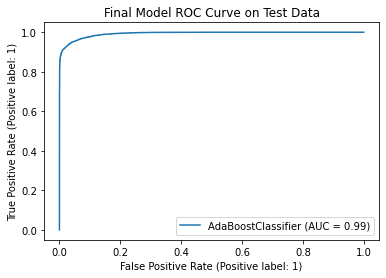

In [11]:
from sklearn.metrics import plot_roc_curve, roc_auc_score
ax = plot_roc_curve(clf_best, test_X, test_y)
ax.ax_.set_title("Final Model ROC Curve on Test Data");

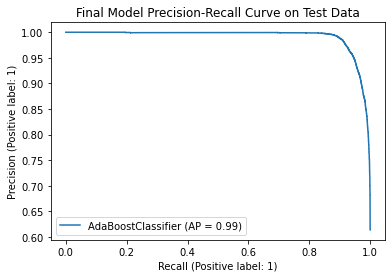

In [12]:
from sklearn.metrics import plot_precision_recall_curve
ax = plot_precision_recall_curve(clf_best, test_X, test_y)
ax.ax_.set_title("Final Model Precision-Recall Curve on Test Data");


**Display Feature Importance**<br/>

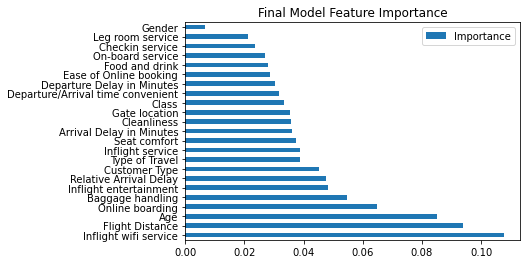

In [13]:
feature_df = pd.DataFrame(data={'Importance':clf_best.feature_importances_}, index=train_X.columns)
feature_df.sort_values(by='Importance', ascending=False, inplace=True)
feature_df.plot(kind='barh')
plt.title('Final Model Feature Importance'); print()

**Quantify and Rank Factors that Impact Customer Satisfaction**<br/>

Let's imagine the following experiment: <br/>
If all the passengers who responded to, say, ‘On-board service’ with a 3 (out of 5) were to increase their scores to 4, how would this group's average satisfaction change?<br/>
Taking the argument one step futher, we can also estimate how overall satisfaction would change if the average score, say, in Cleanliness Category, were to increase by 0.5 on average, spread across various score groups. <br/> <br/>
These datapoints, coupled with some other data, say, cost of improving these factors, could lead the company to prioritize initiatives.



In [14]:
#build a model on relative delay (and flight characteristics (distance)) for prospective deployments

In [15]:
levels = [1,2,3,4,5]

#generate a df that holds satisfaction percentages conditional on survey scores.
base_df = pd.DataFrame(data = np.nan, columns=vars_cat_num, index=levels)

#generate a df that holds the results where category score increases by 1
increase_df = base_df.copy() 


for cat in vars_cat_num:
    _ = test_data_final.groupby(cat).mean()['satisfaction'].sort_index()
    base_df[cat]=_

def increase_by_one(df, cat, lvl):
    '''Increase the score of a certain survey category by 1 while scores on the rest 
    of the categories are unchanged. Return the new population.'''
    _ = df[df[cat] == lvl]
    _inc = _.copy()
    _inc[cat] = _inc[cat] + 1
    return _inc#.drop(['Gender', 'Gate location'], axis=1)

#Run for each category score that one could increase the score
for lvl in [1,2,3,4]:
    for cat in vars_cat_num:
        _ = increase_by_one(test_data_final, cat, lvl).drop(['satisfaction'], axis=1)
        increase_df.loc[lvl][cat] = clf_best.predict(_).mean()

#create a dataframe representing the average satisfaction change 
#(i.e. all Category and level pairs)
inc_sat_chg_df = increase_df - base_df

print('Average Satisfaction per Category and Score - Test Data')
pd.set_option('display.float_format',  '{:.1%}'.format)
base_df.T




Average Satisfaction per Category and Score - Test Data


,1,2,3,4,5
Inflight wifi service,36.4%,25.3%,26.8%,61.1%,98.7%
Departure/Arrival time convenient,50.2%,44.2%,44.2%,38.3%,41.3%
Ease of Online booking,39.5%,31.2%,32.6%,53.3%,71.0%
Gate location,50.6%,46.5%,33.4%,38.9%,55.1%
Food and drink,16.8%,37.9%,39.7%,52.7%,55.4%
Online boarding,12.5%,10.6%,14.2%,61.9%,86.7%
Seat comfort,19.5%,20.2%,20.7%,55.6%,65.8%
Inflight entertainment,10.7%,17.5%,26.4%,61.4%,66.6%
On-board service,17.9%,23.8%,30.2%,52.4%,67.2%
Leg room service,17.1%,25.6%,26.5%,58.6%,62.0%


The above table shows the base case where each cell represents the average satisfaction based on category and survey score.

In [16]:
print("Impact of Score Increase by 1 (e.g. (Inflight wifi service, 4) refers to the experiment where Base Score of 4 was increased to 5:\n{0:.1%} to {1:.1%}".format(base_df['Inflight wifi service'][4], increase_df['Inflight wifi service'][4] ))
print("Average Satisfaction after Scores increase by 1")
present_increase = increase_df.T.copy()
present_increase.columns=["1->2", "2->3", "3->4", "4->5", "N/A"]
present_increase

Impact of Score Increase by 1 (e.g. (Inflight wifi service, 4) refers to the experiment where Base Score of 4 was increased to 5:
61.1% to 88.3%
Average Satisfaction after Scores increase by 1


,1->2,2->3,3->4,4->5,N/A
Inflight wifi service,35.0%,24.8%,41.5%,88.3%,NaN
Departure/Arrival time convenient,50.1%,42.4%,42.7%,37.7%,NaN
Ease of Online booking,39.5%,30.8%,32.6%,51.9%,NaN
Gate location,18.6%,44.2%,33.0%,37.0%,NaN
Food and drink,15.1%,37.4%,38.7%,53.1%,NaN
Online boarding,12.1%,9.6%,17.9%,71.6%,NaN
Seat comfort,18.0%,17.7%,20.8%,62.3%,NaN
Inflight entertainment,11.0%,16.4%,25.9%,61.9%,NaN
On-board service,16.8%,24.1%,29.0%,54.2%,NaN
Leg room service,16.4%,24.3%,26.6%,58.4%,NaN


The table above is the "Experiment" result which represents how an increase in survey score in a single category translates to average satisfaction.

In [17]:
inc_sat_chg_df

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
1,-1.4%,-0.1%,-0.0%,-31.9%,-1.7%,-0.5%,-1.5%,0.3%,-1.1%,-0.7%,0.2%,-0.1%,-0.5%,-1.8%
2,-0.5%,-1.8%,-0.4%,-2.2%,-0.5%,-1.1%,-2.5%,-1.0%,0.3%,-1.4%,-2.0%,0.8%,-2.0%,-0.5%
3,14.7%,-1.5%,0.0%,-0.4%,-1.1%,3.6%,0.1%,-0.5%,-1.2%,0.0%,-0.0%,-0.8%,-0.4%,-2.3%
4,27.2%,-0.6%,-1.4%,-1.9%,0.5%,9.7%,6.7%,0.5%,1.7%,-0.1%,5.4%,6.9%,4.9%,6.8%
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Represents the net average satisfaction change for each "experiment". 
Coupled with weights in the survey, this dataframe can help estimate changes in average satisfaction given an improvement initiative in a category.


Text(0.5, 1.0, 'Net Satisfaction Change for Each Simulation')

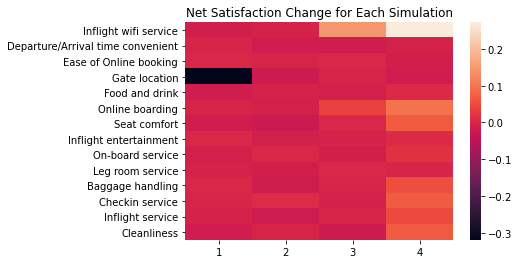

In [18]:
ax = sns.heatmap(data =inc_sat_chg_df.T.loc[:,0:4]);

ax.set_title("Net Satisfaction Change for Each Simulation")


In the above, lighter colors point to larger increases in average satisfaction given a unit increase in survey response. <br/>
In the next part, we will see the aggreage impact of these individual increases per category.

**Impact on Average Satisfaction Given Unit Increases in Each Category**<br/>

Let's complete our experiment by increasing each survey response by 1 where possible and observing the change in average satisfaction. <br/>

In [19]:
#Generate survey weights from test data. This gives an idea of the score distribution in each category.
survey_weights_test = pd.DataFrame()
for cat in vars_cat_num:
    _ = train_data_final[cat].value_counts(normalize=True)
    survey_weights_test[cat] = _

survey_weights_test.sort_index()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
1,17.3%,15.9%,17.6%,16.8%,12.2%,10.4%,11.3%,11.6%,11.3%,9.8%,6.7%,12.6%,6.5%,12.7%
2,25.8%,17.7%,24.3%,18.7%,21.2%,17.3%,14.1%,16.7%,14.2%,18.6%,11.0%,12.6%,11.0%,15.4%
3,25.9%,18.4%,24.7%,27.3%,21.4%,21.6%,18.0%,18.2%,21.7%,19.3%,20.2%,27.4%,19.8%,23.7%
4,19.6%,25.6%,19.6%,23.4%,23.7%,30.4%,31.0%,29.0%,30.0%,28.3%,36.3%,28.0%,36.8%,26.4%
5,11.4%,22.4%,13.9%,13.7%,21.5%,20.2%,25.6%,24.6%,22.7%,24.0%,25.8%,19.5%,25.8%,21.9%


Following cell runs our experiment based on the above weight data:

In [20]:
unit_inc_experiment_result = pd.DataFrame((survey_weights_test*inc_sat_chg_df).sum().sort_values(ascending=False), columns = ['Impact of 1 Point Increase'])
unit_inc_experiment_result['Baseline Satisfaction'] = test_data_final['satisfaction'].mean()
print(test_data_final['satisfaction'].mean())
unit_inc_experiment_result['Satisfaction After 1 Point Increase'] = unit_inc_experiment_result['Impact of 1 Point Increase'] + unit_inc_experiment_result['Baseline Satisfaction']
pd.set_option('display.float_format',  '{:.1%}'.format)
print("Impact of 1 Point Increase on Average Satisfaction (Sorted)")
unit_inc_experiment_result

0.43028290386313
Impact of 1 Point Increase on Average Satisfaction (Sorted)


,Impact of 1 Point Increase,Baseline Satisfaction,Satisfaction After 1 Point Increase
Inflight wifi service,8.8%,43.0%,51.8%
Online boarding,3.5%,43.0%,46.5%
Checkin service,1.8%,43.0%,44.8%
Baggage handling,1.8%,43.0%,44.8%
Seat comfort,1.6%,43.0%,44.6%
Inflight service,1.5%,43.0%,44.5%
Cleanliness,0.9%,43.0%,44.0%
On-board service,0.2%,43.0%,43.2%
Inflight entertainment,-0.1%,43.0%,42.9%
Leg room service,-0.3%,43.0%,42.7%


The above experiment indicates that "Inflight wifi service" and "Online boarding" could be the most important factors in increasing the average satisfaction rate.<br/><br/>
A recommendation for the company is to prioritize improvements in the above two categories given they make sense from a cost per satisfaction change perspective.
